In [130]:
!pip install tldextract

In [131]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [132]:
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head()

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com


In [133]:
import tldextract

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
alexa_dataframe.head()

,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [134]:
from sklearn.model_selection import train_test_split

alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()

# Set the class
alexa_dataframe['class'] = 'legit'

# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print ('Total Alexa domains %d' % alexa_total)

print ('Number of Alexa domains: %d' % alexa_dataframe.shape[0])

Total Alexa domains 91377
Number of Alexa domains: 91377


In [135]:
alexa_dataframe.head()

,domain,class
49345,pepperdine,legit
162,wikimedia,legit
92840,bankislam,legit
70176,jinconvert,legit
37639,fantlab,legit


In [136]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print ('Total DGA domains %d' % dga_total)

# Set the class
dga_dataframe['class'] = 'dga'

print ('Number of DGA domains: %d' % dga_dataframe.shape[0])

Total DGA domains 2664
Number of DGA domains: 2664


In [137]:
dga_dataframe.head()

,domain,class
0,04055051be412eea5a61b7da8438be3d,dga
1,1cb8a5f36f,dga
2,30acd347397c34fc273e996b22951002,dga
3,336c986a284e2b3bc0f69f949cb437cb,dga
5,40a43e61e56a5c218cf6c22aca27f7ee,dga


In [138]:
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

In [139]:
all_domains.sample(5)

,domain,class
31430,fabguys,legit
58053,budgetsavvydiva,legit
89266,primrose,legit
29582,aei-ideas,legit
69998,uabc,legit


In [140]:
# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Since we're trying to detect dynamically generated domains and short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

In [141]:
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [142]:
# Add a entropy field for the domain
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [143]:
all_domains.sample(5)

,domain,class,length,entropy
12759,meteoweb,legit,8,2.405639
88014,mopvideo,legit,8,2.750000
28478,nymphdate,legit,9,3.169925
92819,lztndjhv,dga,8,3.000000
82902,newwoman,legit,8,2.500000


In [144]:
all_domains.tail()

,domain,class,length,entropy
94036,xdbrbsbm,dga,8,2.405639
94037,xdfjryydcfwvkvui,dga,16,3.500000
94038,xdjlvcgw,dga,8,3.000000
94039,xdrmjeu,dga,7,2.807355
94040,xflrjyyjswoatsoq,dga,16,3.500000


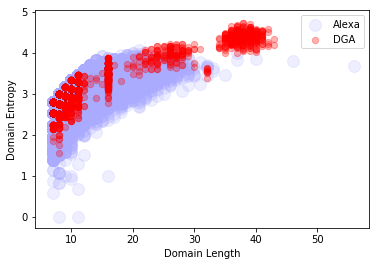

In [145]:
# Split the classes up so we can set colors, size, labels
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Domain Entropy')

# Below you can see that our DGA domains do tend to have higher entropy than Alexa on average.

In [146]:
# Lets put all of the domains with entropy higher than 4 in a different object
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print('Num Domains above 4 entropy: %.2f%% %d (out of %d)' % (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0]))

print ("Num high entropy legit: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0])
print ("Num high entropy DGA: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0])
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Looking at the results below, we do see that there are more domains
# in the DGA group that are high entropy but only a small percentage
# of the domains are in that high entropy range...

Num Domains above 4 entropy: 0.52% 366 (out of 69976)
Num high entropy legit: 3
Num high entropy DGA: 363


,domain,class,length,entropy
2934,burzhunetdlyachaynikov,legit,22,4.004886
3418,theukwebdesigncompany,legit,21,4.070656
46971,congresomundialjjrperu2009,legit,26,4.056021


In [147]:
# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors 
X = all_domains.as_matrix(['length', 'entropy'])

# Labels 
y = np.array(all_domains['class'].tolist())

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

clf = RandomForestClassifier(n_estimators=20) # Trees in the forest

In [149]:
scores = cross_val_score(clf, X, y, cv=5, n_jobs=4)
print(scores)

[ 0.96891969  0.9680623   0.96991783  0.96620222  0.96412748]


In [150]:
# At this point we could claim success but it isn't
# Recall that we have ~100k 'legit' domains and only 3.5k DGA domains
# So a classifier that marked everything as legit would be about
# 96% accurate....

# So we dive in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.88% (13427/13443)
legit/dga: 0.12% (16/13443)
dga/legit: 84.27% (466/553)
dga/dga: 15.73% (87/553)


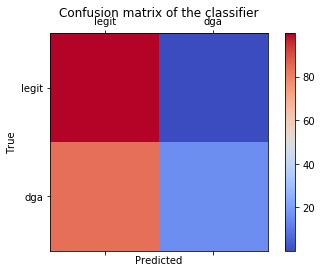

In [151]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

plot_cm(cm, labels)

# We can see below that our suspicions were correct and the classifier is marking almost everything as Alexa.

In [152]:
# going to compute NGrams for every Alexa domain and see if we can use the
# NGrams to help us better differentiate and mark DGA domains...

# Scikit learn has a nice NGram generator that can generate either char NGrams or word NGrams (we're using char).
# Parameters: 
#       - ngram_range=(3,5)  # Give me all ngrams of length 3, 4, and 5
#       - min_df=1e-4        # Minimumum document frequency. At 1e-4 we're saying give us NGrams that 
#                            # happen in at least .1% of the domains (so for 100k... at least 100 domains)
from sklearn.feature_extraction.text import CountVectorizer

alexa_vc = CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [153]:
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [154]:
# We're also going to add dictionary words
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head(10)

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa
55,aaal
56,aaas
57,aaberg
58,aachen
59,aae


In [155]:
# Now compute NGrams on the dictionary words
# Same logic as above...
dict_vc = CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [156]:
# Compute NGram matches for all the domains and add to our dataframe
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
0,pepperdine,legit,10,2.370951,30.476420,50.268515
1,wikimedia,legit,9,2.641604,30.748062,32.116992
2,bankislam,legit,9,2.947703,29.191814,32.446162
3,jinconvert,legit,10,3.121928,38.080021,53.238091
4,fantlab,legit,7,2.521641,15.306144,21.450310


In [157]:
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'], ascending=True).head(10)

,domain,class,length,entropy,alexa_grams,word_grams,diff
16046,bipolardisorderdepressionanxiety,legit,32,3.616729,117.312465,190.833856,-73.521391
85186,channel4embarrassingillnesses,legit,29,3.440070,95.786979,169.119440,-73.332460
27280,stirringtroubleinternationally,legit,30,3.481728,134.049367,207.204729,-73.155362
22281,americansforresponsiblesolutions,legit,32,3.667838,148.143049,218.363956,-70.220908
59599,pragmatismopolitico,legit,19,3.326360,61.244630,121.536223,-60.291593
46832,egaliteetreconciliation,legit,23,3.186393,91.938518,152.125325,-60.186808
40121,interoperabilitybridges,legit,23,3.588354,95.037285,153.626312,-58.589028
54047,foreclosurephilippines,legit,22,3.447402,74.506548,132.514638,-58.008090
87985,annamalicesissyselfhypnosis,legit,27,3.429908,68.680068,126.667692,-57.987623
4104,corazonindomablecapitulos,legit,25,3.813661,75.535473,133.160690,-57.625217


In [158]:
all_domains.sample(5)

,domain,class,length,entropy,alexa_grams,word_grams,diff
42663,3dsecure,legit,8,2.750000,21.778331,24.350390,-2.572059
50289,vector-images,legit,13,3.546594,48.743518,46.215840,2.527678
21219,sakuhindb,legit,9,3.169925,15.332644,18.250919,-2.918275
17104,meishujia,legit,9,2.947703,18.059638,18.344554,-0.284916
30403,yourinsure,legit,10,2.921928,34.895577,48.483858,-13.588281


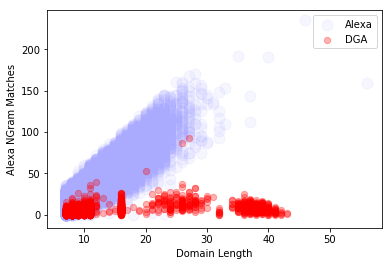

In [159]:
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Length')
plt.ylabel('Alexa NGram Matches')

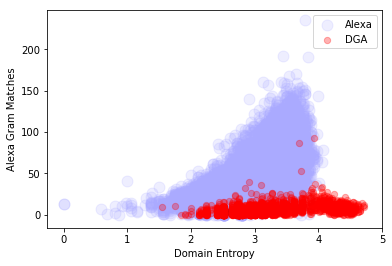

In [160]:
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
plt.xlabel('Domain Entropy')
plt.ylabel('Alexa Gram Matches')

In [161]:
# Lets look at which Legit domains are scoring low on the word gram count
all_domains[(all_domains['word_grams']==0)].head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
466,fzzfgjj,legit,7,1.950212,1.000000,0.0,1.000000
710,0731fdc,legit,7,2.807355,0.000000,0.0,0.000000
879,9611111,legit,7,1.148835,4.474085,0.0,4.474085
1271,4455444,legit,7,0.863121,0.000000,0.0,0.000000
1486,gcwu123,legit,7,2.807355,2.264818,0.0,2.264818


In [162]:
#Lets use some nice Pandas functionality to look at some statistics around our new features.
all_domains[all_domains['class']=='legit'].describe()

,length,entropy,alexa_grams,word_grams,diff
count,67312.000000,67312.000000,67312.000000,67312.000000,67312.000000
mean,10.866829,2.930054,33.398382,40.722037,-7.323655
std,3.385662,0.346481,19.499416,23.238034,9.343186
min,7.000000,-0.000000,0.000000,0.000000,-73.521391
25%,8.000000,2.725481,19.230483,23.923049,-12.451838
50%,10.000000,2.947703,28.978723,36.119830,-6.693223
75%,13.000000,3.169925,42.852118,52.856210,-1.595678
max,56.000000,4.070656,235.233896,233.648571,74.518116


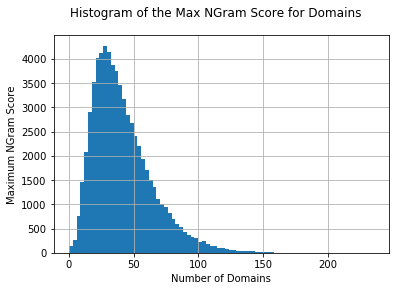

In [163]:
# Lets look at how many domains that are both low in word_grams and alexa_grams (just plotting the max of either)
legit = all_domains[(all_domains['class']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=80)
ax.figure.suptitle('Histogram of the Max NGram Score for Domains')
plt.xlabel('Number of Domains')
plt.ylabel('Maximum NGram Score')

In [164]:
# Lets look at which Legit domains are scoring low on both alexa and word gram count
suspicious_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['alexa_grams']<2)
suspicious = all_domains[suspicious_cond]
print(suspicious.shape[0])
suspicious.head(30)

91


,domain,class,length,entropy,alexa_grams,word_grams,diff
466,fzzfgjj,legit,7,1.950212,1.000000,0.000000,1.000000
710,0731fdc,legit,7,2.807355,0.000000,0.000000,0.000000
1271,4455444,legit,7,0.863121,0.000000,0.000000,0.000000
2873,aek1924,legit,7,2.807355,0.000000,0.000000,0.000000
3352,xn--42cgk1gc8crdb1htg3d,legit,23,3.849224,1.342423,2.411620,-1.069197
3485,jlccptt,legit,7,2.235926,1.000000,2.397940,-1.397940
3869,hzsxzhyy,legit,8,2.250000,0.000000,0.000000,0.000000
6508,as42926,legit,7,2.521641,0.000000,0.000000,0.000000
7213,blt17688,legit,8,2.750000,1.146128,0.000000,1.146128
7668,gyxrmyy,legit,7,2.128085,1.462398,1.944483,-0.482085


In [165]:
# Conclusion is that Alexa really may not be the best 'exemplar' set
# Perhaps we should have two categories of Alexa domains, 'legit' and a 'suspicious'. based on some definition of suspicious.
# Looking at the entries above... we have approx 80 domains that we're going to mark as 'suspicious'.

all_domains.loc[suspicious_cond, 'class'] = 'suspicious'
print(all_domains['class'].value_counts())
all_domains[all_domains['class'] == 'suspicious'].head()

legit         67221
dga            2664
suspicious       91
Name: class, dtype: int64


,domain,class,length,entropy,alexa_grams,word_grams,diff
466,fzzfgjj,suspicious,7,1.950212,1.000000,0.00000,1.000000
710,0731fdc,suspicious,7,2.807355,0.000000,0.00000,0.000000
1271,4455444,suspicious,7,0.863121,0.000000,0.00000,0.000000
2873,aek1924,suspicious,7,2.807355,0.000000,0.00000,0.000000
3352,xn--42cgk1gc8crdb1htg3d,suspicious,23,3.849224,1.342423,2.41162,-1.069197


In [166]:
# Now we try our machine learning algorithm again with the new features
# Alexa and Dictionary NGrams and the exclusion of the bad exemplars.
X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(all_domains['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.73% (13434/13471)
legit/suspicious: 0.00% (0/13471)
legit/dga: 0.27% (37/13471)
suspicious/legit: 0.00% (0/20)
suspicious/suspicious: 25.00% (5/20)
suspicious/dga: 75.00% (15/20)
dga/legit: 16.24% (82/505)
dga/suspicious: 0.40% (2/505)
dga/dga: 83.37% (421/505)


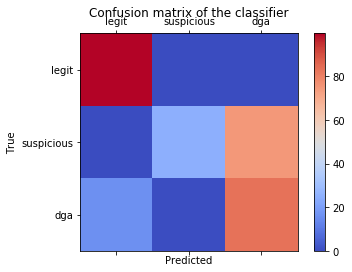

In [167]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'suspicious', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

In [168]:
# Perhaps we will just exclude the suspicious class from our ML training
not_suspicious = all_domains[all_domains['class'] != 'suspicious']
X = not_suspicious.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(not_suspicious['class'].tolist())

# Train on a 80/20 split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Confusion Matrix Stats
legit/legit: 99.53% (13370/13433)
legit/dga: 0.47% (63/13433)
dga/legit: 16.54% (90/544)
dga/dga: 83.46% (454/544)


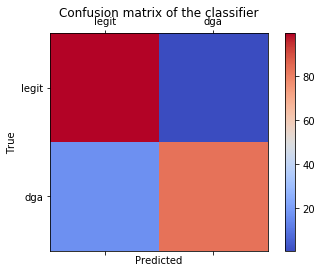

In [169]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels) 